# Customer Segmentation
## by : Farid Arifiyanto

In [1]:
#Load Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")

py.offline.init_notebook_mode(connected = True)

In [2]:
# Reading the data:
data = pd.read_csv(r'transactions.csv')
data.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [3]:
data.dtypes

customer_id     object
trans_date      object
trans_amount     int64
dtype: object

In [4]:
import time

# data['trans_date'] = pd.to_datetime(data.trans_date)

# Error in here, so we comment this code (day is out of range for month: 29-Feb-17)

## Let's check date before and after

In [5]:
data[data['trans_date']=='28-Feb-17'].count()

customer_id     82
trans_date      82
trans_amount    82
dtype: int64

In [6]:
data[data['trans_date']=='29-Feb-17'].count()

customer_id     90
trans_date      90
trans_amount    90
dtype: int64

In [7]:
data[data['trans_date']=='01-Mar-17'].count()

customer_id     91
trans_date      91
trans_amount    91
dtype: int64

In [8]:
data[data['trans_date']=='29-Feb-20'].count()

customer_id     0
trans_date      0
trans_amount    0
dtype: int64

In [9]:
# We Assume the right date for 29-Feb-17 are 29-Feb-20, so we change the date to 29-Feb-20
data['trans_date'] = data['trans_date'].replace(['29-Feb-17'],'29-Feb-20')

In [10]:
data['trans_date'] = pd.to_datetime(data.trans_date)
data.dtypes

customer_id             object
trans_date      datetime64[ns]
trans_amount             int64
dtype: object

In [11]:
# check null values
data.isnull().values.any()

False

In [12]:
# Check duplicates
duplicateDFRow = data[data.duplicated()]
print(duplicateDFRow)

       customer_id trans_date  trans_amount
14324       CS2700 2016-10-23            48
59852       CS3458 2020-02-11            40
77236       CS2761 2019-03-03            75
91603       CS2565 2017-09-14            67
105496      CS7782 2019-12-30            70
121962      CS8394 2018-07-14            16


In [13]:
# Drop duplicates
data=data.drop_duplicates()

# RFM Analysis 

## Recency (how recent was the customer's last purchase)

In [14]:
# First we copy the data
RFM_Data = data.copy()

In [15]:
# Get current date
today = pd.Timestamp.today()
today

Timestamp('2021-08-28 14:05:57.049883')

In [16]:
# Get date difference between all transaction to now
RFM_Data['recency']=(today - RFM_Data['trans_date']).dt.days

In [17]:
RFM_Data.head()

,customer_id,trans_date,trans_amount,recency
0,CS5295,2018-02-11,35,1294
1,CS4768,2020-03-15,39,531
2,CS2122,2018-02-26,52,1279
3,CS1217,2016-11-16,99,1746
4,CS1850,2018-11-20,78,1012


In [18]:
# Get the latest transaction of each customer_id
recency = RFM_Data[['customer_id','recency']].groupby('customer_id').min()
recency.head()

,recency
customer_id,
CS1112,592
CS1113,566
CS1114,563
CS1115,541
CS1116,734


## Frequency (how often did the customer make a purchase in a given period)

In [19]:
frequency=RFM_Data[['customer_id','trans_date']].groupby(['customer_id']).count()
frequency.rename(columns={'trans_date':'frequency'}, inplace=True)
frequency.head()

,frequency
customer_id,
CS1112,15
CS1113,20
CS1114,19
CS1115,22
CS1116,13


## Monetary (how much money did the customer spend in a given period)

In [20]:
monetary = RFM_Data.groupby('customer_id').sum('trans_amount')
monetary.drop(columns=['recency'],axis=1,inplace=True)
monetary.rename(columns={'trans_amount':'monetary'}, inplace=True)
monetary.head()

,monetary
customer_id,
CS1112,1012
CS1113,1490
CS1114,1432
CS1115,1659
CS1116,857


## We Join the R, F and M then do the analysis

In [21]:
RFM = recency.join(frequency) 
RFM = RFM.join(monetary) 

RFM.reset_index(drop=True)
len(RFM.index)

6889

## Data Visualization

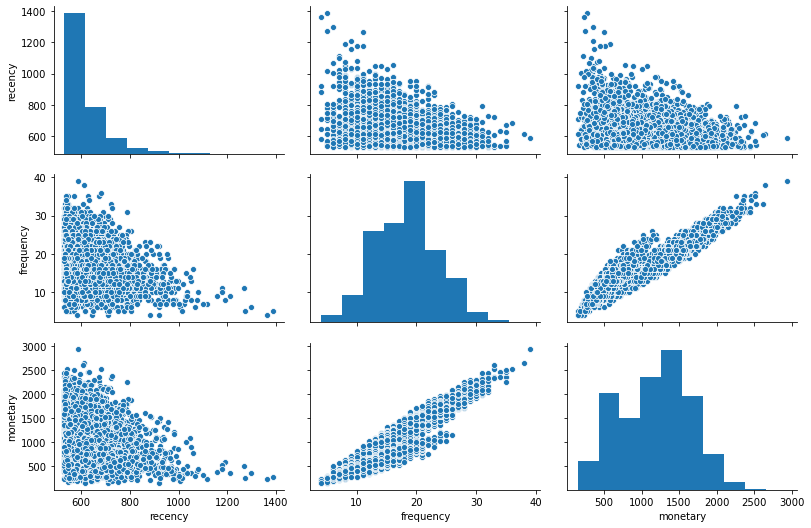

In [22]:
sns.pairplot(RFM, aspect=1.5)
plt.show()

## Standardized Variable (Optional but Strongly Recommended)

In [23]:
standardize = StandardScaler()
X_std = pd.DataFrame(standardize.fit_transform(RFM))
X_std.columns = RFM.columns
X_std

,recency,frequency,monetary
0,-0.215861,-0.605456,-0.359004
1,-0.520343,0.357420,0.667188
2,-0.555476,0.164845,0.542671
3,-0.813114,0.742571,1.030005
4,1.447080,-0.990607,-0.691765
...,...,...,...
6884,0.205729,-0.990607,-1.282147
6885,2.126309,-0.798032,-1.365874
6886,0.053488,-0.990607,-1.191979
6887,2.079465,-1.183182,-1.709369


In [24]:
X_std.describe()

,recency,frequency,monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,-6.436038e-16,-2.310373e-16,-1.320213e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.419338e-01,-2.723785e+00,-2.211731e+00
25%,-6.842951e-01,-7.980317e-01,-8.549248e-01
50%,-3.212587e-01,-2.773040e-02,1.025680e-01
75%,3.579705e-01,7.425709e-01,7.315936e-01
max,9.105975e+00,4.016351e+00,3.765085e+00


## K-Means: with 2 variables with speculated k

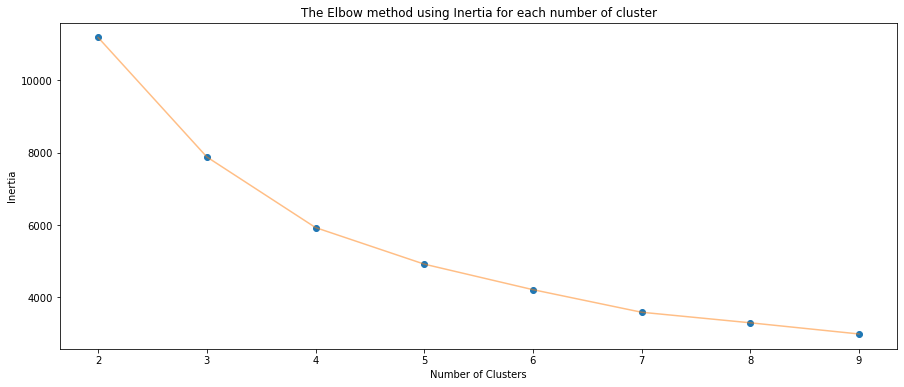

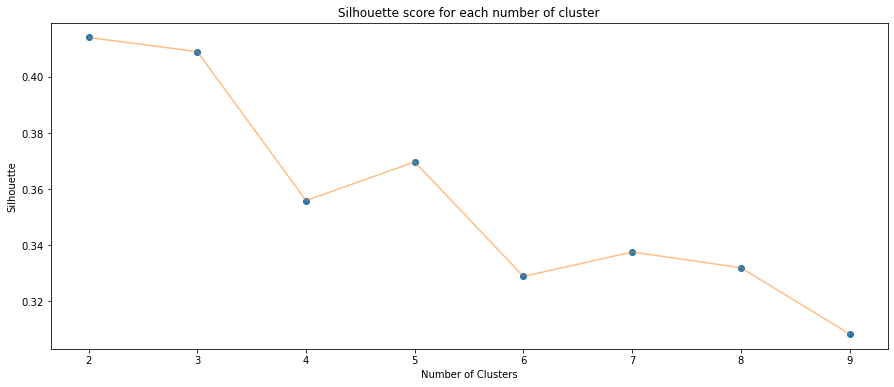

In [25]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

inertia, silhouette = k_means_inertia_silhouette(X = X_std)

In [26]:
k = 4
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(X_std)

segment = k_means.labels_
segment

array([1, 1, 1, ..., 2, 3, 2], dtype=int32)

In [27]:
km_cluster = k_means.cluster_centers_
km_cluster

array([[-0.35231854,  1.27346025,  1.22366136],
       [-0.19822473,  0.08619429,  0.17929222],
       [-0.18921958, -1.04137093, -1.15046043],
       [ 2.3393286 , -0.94979436, -0.91531285]])

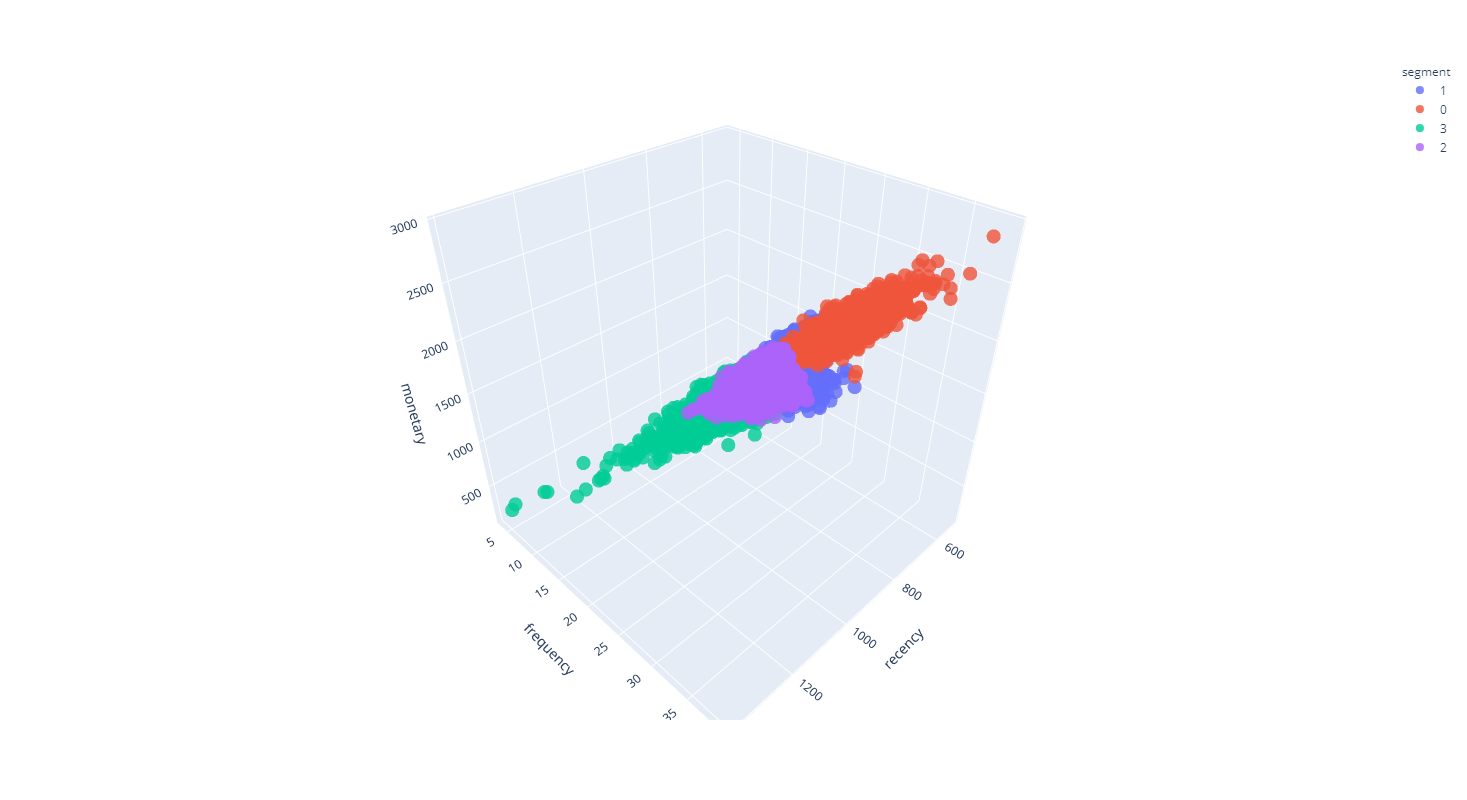

In [28]:
RFM['segment'] = list(map(str, segment))
fig = px.scatter_3d(RFM, x='recency', y='frequency', z='monetary', color='segment',opacity = 0.8, height=800)
fig.show() # to show as static image: fig.show('svg')

In [29]:
RFM

,recency,frequency,monetary,segment
customer_id,,,,
CS1112,592,15,1012,1
CS1113,566,20,1490,1
CS1114,563,19,1432,1
CS1115,541,22,1659,0
CS1116,734,13,857,3
...,...,...,...,...
CS8996,628,13,582,2
CS8997,792,14,543,3
CS8998,615,13,624,2


In [33]:
RFM['segment_name'] = 'HIGH'
RFM.loc[RFM['segment']=='3','segment_name'] = 'LOW' 
RFM.loc[RFM['segment']=='2','segment_name'] = 'MDDILE_LOW'
RFM.loc[RFM['segment']=='1','segment_name'] = 'MDDILE_HIGH'
RFM
Data_segment = RFM.groupby('segment_name').agg({'recency' : ['count','min','max','mean'], 'frequency' : ['count','min','max','mean'], 'monetary':['count','min','max','mean']}).reset_index()
Data_segment

segment_name recency                        frequency                     \
                 count  min   max        mean     count min max       mean   
0         HIGH    1732  530   805  580.417436      1732  20  39  24.754619   
1          LOW     637  699  1388  810.189953       637   4  23  13.211931   
2  MDDILE_HIGH    2756  530   770  593.466981      2756  14  26  18.590711   
3   MDDILE_LOW    1764  530   713  594.274943      1764   4  19  12.736395   

  monetary                           
     count   min   max         mean  
0     1732  1151  2933  1749.157621  
1      637   157  1613   752.871272  
2     2756   684  1658  1262.591437  
3     1764   149  1079   643.339569

## Conclusion
1. HIGH Customer is a loyal customer that spend highest money and more frequent thent others
2. MIDDLE HIGH Customer is a loyal customer that spend higher money on less frequent then HIGH Customer
3. MIDDLE LOW Customer is a customer that rarely spend money 
4. LOW Customer is a customer that buy our product in a long time ago and rarely spend money